# Generate xyz with rdkit

In [17]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
import seaborn as sns
from mlsaft.pipelines.data_processing.nodes import classify_molecules

In [3]:
df = pd.read_csv("../data/03_primary/pcp_saft_cleaned.csv")
df =  df.dropna(subset="Smiles")

In [12]:
for row_idx, row in df.iterrows():
    name = row["Name"]
    smiles = row["Smiles"]
    
    # adapted from 3dinfomax - qm9_dataset_rdkit_conformers.py
    # also look at: https://gist.github.com/tdudgeon/b061dc67f9d879905b50118408c30aac
    # get the molecule using the smiles representation from the csv file
    mol = Chem.MolFromSmiles(smiles)
    # add hydrogen bonds to molecule because they are not in the smiles representation
    mol = Chem.AddHs(mol)
    # use rdkit to generate conformer
    #try:
    ps = AllChem.ETKDGv2()
    ps.useRandomCoords = True
    AllChem.EmbedMolecule(mol, ps)
    AllChem.MMFFOptimizeMolecule(mol, confId=0)
    conf = mol.GetConformer()

    # write in xyz-file format
    with open(f"../data/03_primary/rdkit_xyz_files/{name}.xyz", "w") as f:
        f
        f.write(f"{len(mol.GetAtoms())}\n")
        f.write("\n")
        for ai, a in enumerate(mol.GetAtoms()):
            positions = mol.GetConformer().GetAtomPosition(ai)
            f.write(f"  {a.GetSymbol()} {positions.x:.7f} {positions.y:.7f} {positions.z:.7f}\n")
    #except:
    #    print(f"Failed to produce 3D info for {smiles}")
    #    continue

## Understanding number of conformers

In [9]:
df = pd.read_csv("../data/01_raw/crc_dipoles.csv")
classify_molecules(df, smiles_column="SMILES")

[15:01:54] Explicit valence for atom # 1 Br, 5, is greater than permitted
[15:01:54] Explicit valence for atom # 1 Br, 4, is greater than permitted
[15:01:54] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[15:01:54] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[15:01:54] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[15:01:54] Explicit valence for atom # 1 Cl, 7, is greater than permitted
[15:01:54] Explicit valence for atom # 1 Br, 2, is greater than permitted


,Name,SMILES,status
0,Difluorosilane,F[SiH2]F,Exclude
1,Lead(II) oxide,O=[Pb],Exclude
2,Difluorine dioxide,FOOF,Include
3,Ozone,O=[O+][O-],Exclude
4,Fluorogermane,F[GeH3],Exclude
...,...,...,...
694,5-Trioxane,C1OCOCO1,Include
695,4-Xylenol,CC1=CCC(C)(O)C=C1,Include
696,5-Xylenol,CC1=CC(C)(O)CC=C1,Include
697,Vinyl acetate,C=COC(C)=O,Include


In [41]:
def min_conformer_energy(smiles, nconf):
    mol = Chem.MolFromSmiles(smiles)  # type: ignore
    mol = Chem.AddHs(mol)  # type: ignore

    ps = AllChem.ETKDGv3()  # type: ignore
    ps.useRandomCoords = True
    ps.pruneRmsThresh = 0.5
    cids = AllChem.EmbedMultipleConfs(mol, nconf, ps)  # type: ignore
    mp = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94s')
    results = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=0, mmffVariant='MMFF94s')

    # Find minimum energy conformer
    energies = [r[1] for r in results if r[0]==0]
    if len(energies) > 0:
        return np.min(energies)
    else:
        return None

In [42]:
df_include = df[df["status"]=="Include"]


In [46]:
energies_list = [{}] * len(df_include)
for i,smiles in tqdm(enumerate(df_include["SMILES"]), total=len(df_include)):
    min_energies = {
        nconf: min_conformer_energy(smiles, nconf)
        for nconf in [10, 50, 100, 200]
    }
    min_energies.update({"smiles": smiles})
    energies_list.append(min_energies)
df_energies = pd.DataFrame(energies_list)

  2%|█▊                                                                            | 10/441 [00:00<00:16, 26.28it/s][15:50:42] UFFTYPER: Unrecognized charge state for atom: 0
[15:50:42] UFFTYPER: Unrecognized charge state for atom: 0
[15:50:42] UFFTYPER: Unrecognized charge state for atom: 0
[15:50:42] UFFTYPER: Unrecognized charge state for atom: 0
  6%|████▊                                                                         | 27/441 [00:02<00:49,  8.35it/s][15:50:45] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[15:50:45] UFFTYPER: Unrecognized charge state for atom: 1
[15:50:45] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[15:50:45] UFFTYPER: Unrecognized charge state for atom: 1
[15:50:45] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[15:50:45] UFFTYPER: Unrecognized charge state for atom: 1
[15:50:45] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[15:50:45] UFFTYPER: Unrecognized charge state for atom: 1
  9%|██████▋                    

In [52]:
df_energies = pd.DataFrame(energies_list)

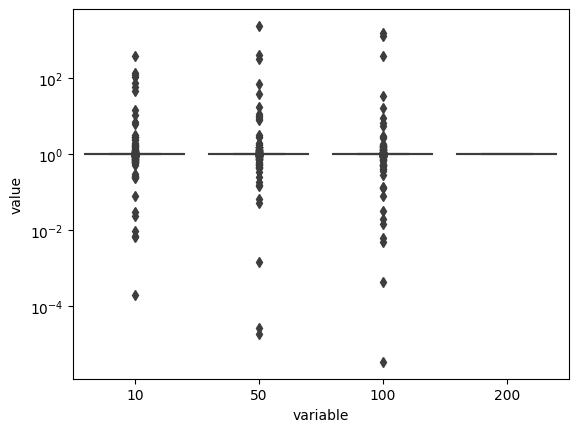

In [47]:
df_energies_ratios = df_energies.copy()
for col in [10, 50, 100, 200]:
    df_energies_ratios[col] = df_energies[col]/df_energies[200]
fig, ax = plt.subplots(1)
sns.boxplot(
    data=df_energies_ratios[[10, 50, 100, 200]].melt(),
    x="variable",
    y="value",
    ax=ax,
)
ax.set_yscale("log")

In [49]:
sorts = df_energies_ratios.dropna().sort_values(10, ascending=False).index
df_energies.reindex(sorts).head(20)

,10,50,100,200,smiles
452,4.921695e-13,4.149467e-13,5.073165e-13,1.294086e-15,FI
463,1.813531e-10,1.304097e-11,2.158533e-11,1.299850e-12,S
555,1.694645e-12,3.244119e-11,2.135530e-11,1.355498e-14,N#CF
467,1.754424e-10,1.173119e-12,8.800259e-12,1.575706e-12,O=S=O
460,1.192141e-10,1.911043e-11,6.494879e-13,1.614727e-12,N
444,1.653228e-11,1.141729e-10,1.845382e-12,2.722300e-13,FOF
539,8.021971e-11,1.220630e-10,5.208781e-12,1.764326e-12,N#CI
449,1.347144e-10,1.348138e-11,1.278329e-12,9.468065e-12,NF
442,2.287213e-10,1.046169e-12,2.656957e-12,2.056554e-11,O=NF
466,1.057182e-10,2.587865e-10,2.837814e-13,1.452725e-11,FSF


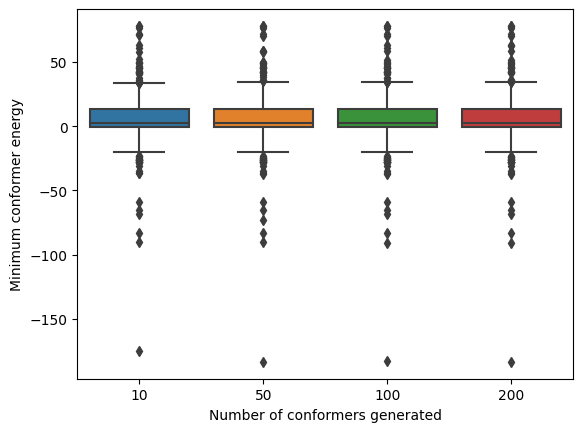

In [54]:
fig, ax = plt.subplots(1)
sns.boxplot(
    data=df_energies[[10, 50, 100, 200]].dropna().melt(),
    x="variable",
    y="value",
    ax=ax,
)
ax.set_ylabel("Minimum conformer energy")
ax.set_xlabel("Number of conformers generated")
fig.savefig("../data/08_reporting/conformer_energies.png", dpi=300)